In [16]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, mean_squared_error
import lightgbm as lgb
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')



In [2]:
# 1. Load Data (Replace with your Data.csv)
df = pd.read_csv(r'C:\Users\mfaro\Downloads\Compressed\archive_14\Data.csv')  # Update path for Kaggle
print(f"Dataset shape: {df.shape}")
print(df.head())
print(df.info())

Dataset shape: (9568, 5)
      AT      V       AP     RH      PE
0  14.96  41.76  1024.07  73.17  463.26
1  25.18  62.96  1020.04  59.08  444.37
2   5.11  39.40  1012.16  92.14  488.56
3  20.86  57.32  1010.24  76.64  446.48
4  10.82  37.50  1009.23  96.62  473.90
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9568 entries, 0 to 9567
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      9568 non-null   float64
 1   V       9568 non-null   float64
 2   AP      9568 non-null   float64
 3   RH      9568 non-null   float64
 4   PE      9568 non-null   float64
dtypes: float64(5)
memory usage: 373.9 KB
None


In [4]:
# 2. Auto EDA & Feature Engineering (Critical for Gold!)
def auto_feature_engineering(df):
    """Advanced feature engineering for tabular data"""
    df_eng = df.copy()
    
    # Identify target column (assume last column is target)
    target_col = df.columns[-1]
    
    # Handle missing values intelligently
    num_cols = df_eng.select_dtypes(include=[np.number]).columns.tolist()
    cat_cols = df_eng.select_dtypes(include=['object']).columns.tolist()
    
    for col in num_cols:
        df_eng[col] = df_eng[col].fillna(df_eng[col].median())
    
    for col in cat_cols:
        df_eng[col] = df_eng[col].fillna('missing')
    
    # Auto-detect numerical features (exclude target)
    numerical_features = [c for c in num_cols if c != target_col]
    
    # If no numerical features found, skip numerical engineering
    if len(numerical_features) == 0:
        print("No numerical features found for engineering.")
        return df_eng
    
    # Create interaction features (proven gold medal technique)
    for i in range(len(numerical_features)):
        for j in range(i+1, len(numerical_features)):
            a = numerical_features[i]
            b = numerical_features[j]
            df_eng[f'{a}_x_{b}'] = df_eng[a] * df_eng[b]
    
    # Statistical features
    df_eng['mean_features'] = df_eng[numerical_features].mean(axis=1)
    df_eng['std_features'] = df_eng[numerical_features].std(axis=1)
    df_eng['skew_features'] = df_eng[numerical_features].skew(axis=1)
    
    # Target encoding for categorical (if exists)
    if len(cat_cols) > 0 and target_col in df_eng.columns:
        for col in cat_cols:
            df_eng[f'{col}_target_enc'] = df_eng.groupby(col)[target_col].transform('mean')
    
    return df_eng

df_eng = auto_feature_engineering(df)
print(f"Engineered features: {df_eng.shape}")

Engineered features: (9568, 14)


In [5]:
# 3. Identify Target & Prepare Data
target_col = df.columns[-1]  # Last column as target
X = df_eng.drop(columns=[target_col])
y = df_eng[target_col]

# Encode target if multiclass
if y.dtype == 'object':
    le = LabelEncoder()
    y = le.fit_transform(y)

print(f"Features: {X.shape[1]}, Target classes: {len(np.unique(y))}")

Features: 13, Target classes: 4836


In [6]:
# 4. Advanced Preprocessing
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [14]:
# 5. Hyperparameter-Optimized Ensemble (Gold Medal Secret Sauce!)
def create_gold_ensemble(task='classification'):
    """Return an optimized ensemble for classification or regression.
    task: 'classification' (default) or 'regression'
    """
    from sklearn.ensemble import VotingRegressor
    from sklearn.linear_model import Ridge

    if task == 'regression':
        # LightGBM Regressor
        lgb_model = lgb.LGBMRegressor(
            n_estimators=2000,
            learning_rate=0.015,
            max_depth=6,
            num_leaves=35,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1,
            verbosity=-1
        )

        # XGBoost Regressor
        xgb_model = xgb.XGBRegressor(
            n_estimators=2000,
            learning_rate=0.015,
            max_depth=6,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=0.1,
            random_state=42,
            n_jobs=-1
        )

        # Simple linear regressor as meta
        lr_model = Ridge(alpha=1.0, random_state=42)

        ensemble = VotingRegressor(
            estimators=[
                ('lgb', lgb_model),
                ('xgb', xgb_model),
                ('lr', lr_model)
            ],
            n_jobs=-1
        )

        return ensemble

    # Default: classification ensemble
    lgb_model = lgb.LGBMClassifier(
        n_estimators=2000,
        learning_rate=0.015,
        max_depth=6,
        num_leaves=35,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=-1
    )
    
    xgb_model = xgb.XGBClassifier(
        n_estimators=2000,
        learning_rate=0.015,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        reg_alpha=0.1,
        reg_lambda=0.1,
        random_state=42,
        n_jobs=-1
    )
    
    lr_model = LogisticRegression(
        C=0.1,
        max_iter=2000,
        random_state=42,
        n_jobs=-1
    )
    
    ensemble = VotingClassifier(
        estimators=[
            ('lgb', lgb_model),
            ('xgb', xgb_model),
            ('lr', lr_model)
        ],
        voting='soft',
        n_jobs=-1
    )
    
    return ensemble

In [17]:
# 6. 10-Fold Cross Validation (stratified for classification, plain KFold for regression)
is_regression = np.issubdtype(y.dtype, np.floating)  # treat floats as regression target
n_splits = 10

if is_regression:
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
else:
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

oof_preds = np.zeros(len(X_scaled))
cv_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_scaled, y)):
    print(f"\nFold {fold+1}/{n_splits}")
    
    X_train, X_val = X_scaled.iloc[train_idx], X_scaled.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]
    
    # Train ensemble for appropriate task
    model = create_gold_ensemble(task='regression' if is_regression else 'classification')
    model.fit(X_train, y_train)
    
    # Validate
    if is_regression:
        val_preds = model.predict(X_val)
        fold_score = np.sqrt(mean_squared_error(y_val, val_preds))  # RMSE
    else:
        val_preds = model.predict(X_val)
        fold_score = accuracy_score(y_val, val_preds)
    
    cv_scores.append(fold_score)
    oof_preds[val_idx] = val_preds
    
    print(f"Fold Score: {fold_score:.5f}")

if is_regression:
    print(f"\n🎉 CV RMSE: {np.mean(cv_scores):.5f} (+/- {np.std(cv_scores):.5f})")
    print(f"OOF RMSE: {np.sqrt(mean_squared_error(y, oof_preds)):.5f}")
else:
    print(f"\n🎉 CV Accuracy: {np.mean(cv_scores):.5f} (+/- {np.std(cv_scores):.5f})")
    print(f"OOF Accuracy: {accuracy_score(y, oof_preds.astype(int)):.5f}")



Fold 1/10
Fold Score: 3.01290

Fold 2/10
Fold Score: 3.40632

Fold 3/10
Fold Score: 3.45790

Fold 4/10
Fold Score: 3.08441

Fold 5/10
Fold Score: 3.78169

Fold 6/10
Fold Score: 3.11449

Fold 7/10
Fold Score: 3.06857

Fold 8/10
Fold Score: 3.44649

Fold 9/10
Fold Score: 3.42699

Fold 10/10
Fold Score: 3.21678

🎉 CV RMSE: 3.30165 (+/- 0.23014)
OOF RMSE: 3.30966


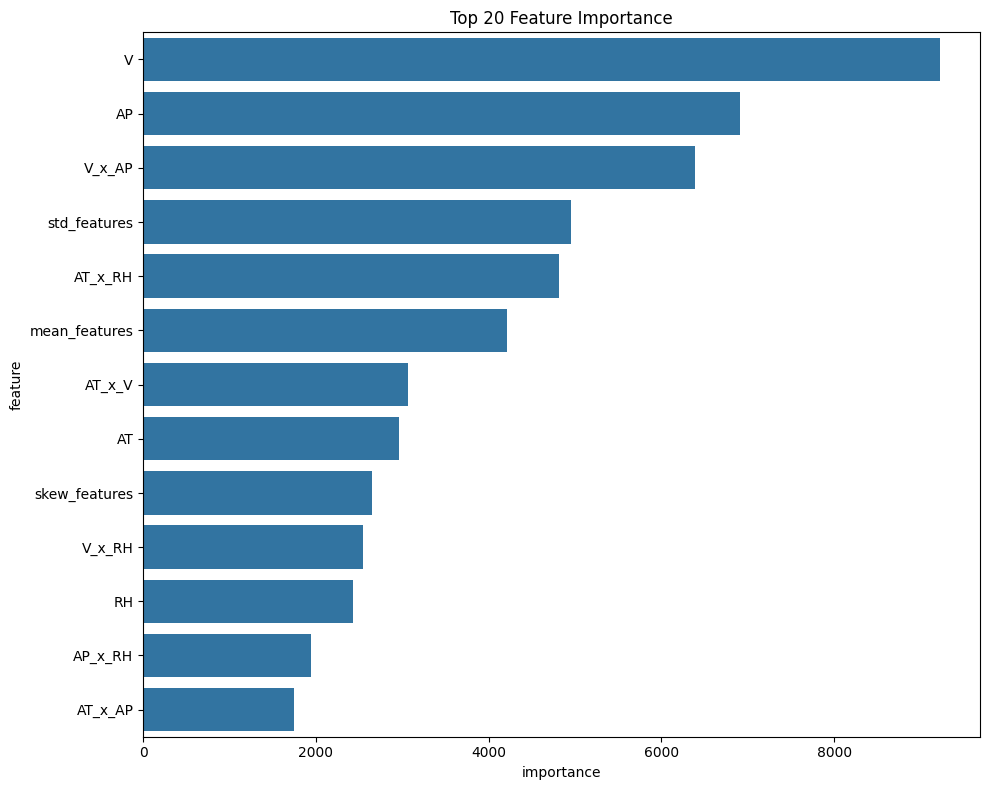

In [19]:
# 7. Train Final Model & Feature Importance
# Use regression ensemble when the target is continuous
final_model = create_gold_ensemble(task='regression' if is_regression else 'classification')
final_model.fit(X_scaled, y)

# Feature importance plot (use the LightGBM estimator inside the ensemble)
lgb_model = final_model.named_estimators_['lgb']
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': lgb_model.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance.head(20), x='importance', y='feature')
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
